##Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import kerastuner as kt
from contextlib import redirect_stdout
import shutil
import locale

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') #This is needed to convert string values of type 1,999.99 
                                               #to float 1999.99

from sklearn.preprocessing import MinMaxScaler

#Load locally stored data:

In [2]:
#Define where are the datasets

#Paths for data with market info
path = os.getcwd()+"/exper_files/datasets/" #Here they are datasets from yahoo
#path = os.getcwd()+"/exper_files/coinmarket/" #Here they are datasets from coinmarket

#Paths for data with social info
social_path = os.getcwd()+"/exper_files/social_datasets/cryptocompare/" #Define where are the datasets from cryptocompare

Create the whole dataset:

In [3]:
def dataset_creation(crypto_list, pth, social_pth, social_use_flag):
    datasets = {} #Store all datasets here
    social_datasets = {} #Store all datasets with social media information here
    
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    
    datasets_list = os.listdir(pth) #Find all dataset
    social_datasets_list = os.listdir(social_pth) #Find all dataset with social media information
    
    splitted_path = path.split('/')
    if splitted_path[-2] == 'coinmarket':
        type_of_file = '.txt'
    
    elif splitted_path[-2] == 'datasets':
        type_of_file = '.csv'
        
    
    social_crypto_list = [elem+'.csv' for elem in crypto_list]
    crypto_list = [elem+type_of_file for elem in crypto_list]
    
    
    for dataset in datasets_list:
        if dataset.endswith(type_of_file) and (dataset) in crypto_list:

            name = dataset.split(".")
            dataset_name = name[0]
            
            if splitted_path[-2] == 'datasets':
                
                datasets[dataset_name] = pd.read_csv(pth + dataset) 

                datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date']) #Dataset from yahoo
                                                                                            #is stored ia .csv file.
                    
                datasets[dataset_name].rename(columns={'Adj Close':dataset_name+'Adj_Close'}) #Space will cause troubles
                
            
            elif splitted_path[-2] == 'coinmarket':  
                    
                lines = []
                with open(pth + dataset) as f: #Dataset from coinmarket is stored in a .txt file, so we need to read it
                                               #line by line.
                    lines = f.readlines()
                
                initial_columns = lines[0].split("\t") #Split the first line to individual words. The first line 
                                                       #contains the column names. 
                columns = []
                for col in initial_columns:
                    clear_col = col.split('*') #Some column names contains * or **, so we need to exclude them
                    clear_col = clear_col[0].split('\n') #The last element cointains a \n
                    
                    if clear_col[0] == 'Market Cap':
                        clear_col[0] = 'Market_Cap' #Space will cause troubles
                    columns.append(clear_col[0])
                
                df = pd.DataFrame(columns=columns) #Define column names
                
                
                for line in range(1, len(lines)):
                    
                    splitted_line = lines[line].split("\t") #Split each line to individual numbers
                    
                    for elem in range(len(splitted_line)):
                        clear_elem = splitted_line[elem].split('$') #All number cointains a $ (except Date) so we need 
                                                                    #throw it away.
                        
                        if len(clear_elem) == 1:
                            splitted_line[elem] = pd.to_datetime(clear_elem[0])#Tranform each Date to 'datetime' type
                            
                        else:
                            clear_elem[1] = clear_elem[1].split('\n')
                            splitted_line[elem] = locale.atof(clear_elem[1][0])
                    
                    #Append each line to the dataframe
                    row_to_append = pd.Series(splitted_line, index=columns)                    
                    df = df.append(row_to_append, ignore_index=True)
                
                #Invert the sorting of values to ascending based on 'Date'
                df = df.sort_values(by=['Date']).reset_index().drop(['index'], axis=1)
                datasets[dataset_name] = df.copy()
            
            #There are a few missing values, so let fill them with the previous value
            datasets[dataset_name].fillna(method='ffill', inplace=True)

            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }

            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1
            

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
            
    
    
    #Get social media information for each coin from the corresponding csv
    if social_use_flag:
        for dataset in social_datasets_list:
            if dataset.endswith(".csv") and (dataset) in social_crypto_list:

                name = dataset.split(".")
                dataset_name = name[0]

                social_datasets[dataset_name] = pd.read_csv(social_pth + dataset) 

                social_datasets[dataset_name]['time'] = pd.to_datetime(social_datasets[dataset_name]['time'])

                #Drop first column which is an unused index
                social_datasets[dataset_name] = social_datasets[dataset_name].iloc[:, 1:]

                #We observed that there are many zero rows at social media datasets.
                #We should find the first row which is non-zero
                res = [next(((j, i) for i, j in enumerate(social_datasets[dataset_name][col]) if j != 0), (0, 0)) 
                       for col in social_datasets[dataset_name] if col != 'time']

                #Get all columns except 'time'
                columns_except_time = [col for col in social_datasets[dataset_name].columns if col != 'time']

                #Store the index of each column with the first non-zero element
                df_res = pd.DataFrame(res, columns=['value', 'position'], index=columns_except_time)

                #Get the minimum of these indices
                first_non_zero_row = df_res['position'].min()


                first_date = pd.to_datetime(social_datasets[dataset_name]['time'][first_non_zero_row])
                if first_date >  min_dates[dataset_name]:
                     min_dates[dataset_name] = first_date

                last_date = pd.to_datetime(social_datasets[dataset_name]['time'].iloc[-1])
                if last_date < max_dates[dataset_name]:
                    max_dates[dataset_name] = last_date
            
    
    
    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]
        
    for dataset in social_datasets:
        social_datasets[dataset] = social_datasets[dataset][(social_datasets[dataset]['time'] >= max_date) & 
                                                            (social_datasets[dataset]['time'] <= min_date)]


    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:

        temp = datasets[dataset].copy()

        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]

        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()

        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()

        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()

        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()

        datasets[dataset] = temp.copy()
        
    
    #Drop the first 30 days of 'social_datasets' to be aligned with 'datasets'
    for dataset in social_datasets:
            social_datasets[dataset] = social_datasets[dataset][29:]
          


    #Rename the columns and concatenate all datasets to one 
    count = 0
    for dataset in datasets:

        datasets[dataset] = datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        datasets[dataset] = datasets[dataset].rename(columns={dataset+'_Date': 'Date'})                                                   
        
        if count == 0:
            
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
            
            
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)    
                    
    
    for dataset in social_datasets:
        
        social_datasets[dataset] = social_datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        
        social_datasets[dataset] = ((social_datasets[dataset].drop([dataset+'_time'], axis=1)).reset_index()).drop(['index'], 
                                                                                                          axis=1) 

    
    
    #Concatenate all datasets to one 
    whole_market_dataset = pd.concat([datasets[dataset] for dataset in datasets], axis=1)
    if len(social_datasets) == len(datasets):
        whole_social_dataset = pd.concat([social_datasets[dataset] for dataset in social_datasets], axis=1)
        whole_dataset = pd.concat([date_col, whole_market_dataset, whole_social_dataset], axis=1)
    else:
        whole_dataset = pd.concat([date_col, whole_market_dataset], axis=1)
    
   
    return whole_dataset

Split data into training, validation and test set:

In [4]:
def split_data(perc_train_set, perc_val_set, currency_data):
        
        #Compute the date to split the dataset into training and validation_test set based on 'perc_train_set'
        splt_date_train = currency_data.iloc[round(currency_data.shape[0] * perc_train_set)]['Date']
        
        #Split the dataset into trainning and validation_test set
        tr_set, val_tst_set = currency_data[currency_data['Date'] < splt_date_train], \
                         currency_data[currency_data['Date'] >= splt_date_train]
        
        #Compute the date to split the val_tst_set into validation and test set based on 'perc_val_set'
        splt_date_val = val_tst_set.iloc[round(val_tst_set.shape[0] * perc_val_set)]['Date']

        #Split the val_tst_set into validation and test set        
        val_set, tst_set = val_tst_set[val_tst_set['Date'] < splt_date_val], \
                            val_tst_set[val_tst_set['Date'] >= splt_date_val]
        
        return tr_set, val_set, tst_set, splt_date_train, splt_date_val

Now, we will normalize training, validation and test inputs with MixMaxScaler.


#Define classification task

Also, here we will define labels for the classification task. If a close value of the target coin *p* in a current date *t* (*p(t)*) is greater or equal than the 99% of the average close value (*99% avg(p(t))*) of the last 30 days (*t-30*), then this is a positive label (*pos*), else it is a negative label (*neg*). In a more formal way:

if: p(t) >= 99% avg(p(t)), where avg(p(t)) = sum(p(t-i))[for i in range(1, 30)], then *pos* 

else: *neg*


This kind of labels will be created for *pred_range* (5) days ahead for every *pred_range* (5) days.

So, the number of output nodes of the Neural Network will be equal to pred_range*2 (5*2=10), because for each day it has to be decided which of the nodes of 1 and 0 is the correct class. Therefore, for each sample to be predicted there will be the following classes: *class_day(1)_pos*, *class_day(1)_neg*, *class_day(2)_pos*, *class_day(2)_neg*, ..., *class_day(pred_range)_pos*, *class_day(pred_range)_neg*.

This means that for each sample to be predicted, we should keep as the predicted label of each day the one with the the greater probability among *class_day(i)_pos*, *class_day(i)_neg*.   



In [5]:
from numpy import inf

def normalize_in_out(prd_range, wind_len, tr_set, val_set, tst_set, feats, coin_targ, crypto_list):
    
    
    #Scaling

    scaler = MinMaxScaler(feature_range=(0, 1)) #Scaler for all columns
    
    
    tr_set = tr_set.drop(['Date'], axis=1)
    #transformed_tr_set_values = np.log(tr_set.values)#((tr_set.values**(-3))-1)/-3
    #transformed_tr_set_values[transformed_tr_set_values == -inf] = 0
    train_scaled_data = pd.DataFrame(scaler.fit_transform(tr_set.values), columns=tr_set.columns, #scaler.fit_transform(transformed_tr_set_values)
                                     index=training_set.index) #Training set fit and transform

    val_set = val_set.drop(['Date'], axis=1) #Keep initial validation set to use average of month close values
    #transformed_val_set_values = np.log(val_set.values)#((val_set.values**(-3))-1)/-3
    #transformed_val_set_values[transformed_val_set_values == -inf] = 0
    val_scaled_data = pd.DataFrame(scaler.transform(val_set.values), columns=val_set.columns, #scaler.transform(transformed_val_set_values)
                                  index=val_set.index) #Validation set just transform

    tst_set = tst_set.drop(['Date'], axis=1) #Keep initial test set to use average of month close values
    #transformed_tst_set_values = np.log(tst_set.values)#((tst_set.values**(-3))-1)/-3
    #transformed_tst_set_values[transformed_tst_set_values == -inf] = 0
    test_scaled_data = pd.DataFrame(scaler.transform(tst_set.values), columns=tst_set.columns, #scaler.transform(transformed_tst_set_values)
                                   index=tst_set.index) #Test set just tranform

    
    all_feats = tr_set.columns #Get all features
    feats = [crypto+"_"+feat for crypto in crypto_list for feat in feats] #Get the features in the appropriate format 
                                                                          #(e.g 'Close' --> 'BTC-USD_Close')
    
    
    #Normalize training inputs
    LSTM_tr_in = []
    for i in range(len(train_scaled_data) - wind_len):
        tmp_set = train_scaled_data[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_tr_in.append(tmp_set)
    
    #Transform from DataFrame to numpy array
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    #Normalize validation inputs
    LSTM_val_in = []
    for i in range(len(val_scaled_data) - wind_len):
        tmp_set = val_scaled_data[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_val_in.append(tmp_set)
        
    #Transform from DataFrame to numpy array
    LSTM_val_in = [np.array(LSTM_val_i) for LSTM_val_i in LSTM_val_in]
    LSTM_val_in = np.array(LSTM_val_in)
    
    
    #Normalize test inputs
    LSTM_test_in = []
    for i in range(len(test_scaled_data) - wind_len):
        tmp_set = test_scaled_data[i:(i + wind_len)].copy() 
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        LSTM_test_in.append(tmp_set)
    
    
    #Transform from DataFrame to numpy array
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    #Create LSTM outputs labels for training. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(train_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = [] #Create a list with pred_range*2 1s and 0s according with the true value of each class
                    #It is obvious that of a day is pos, it cannot be also negative. So, the ground truth of each
                    #day classes it should be 0,1 or 1,0.
        
        for j in range(i, i+prd_range):
            
            if tr_set[coin_targ+'_Close'][j] >= (tr_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
                
            else:
                labels.extend([0, 1])
        
        
        LSTM_rangd_train_out.append(labels)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    
    #Create LSTM outputs labels for validation. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)    
    LSTM_rangd_val_out = []
    
    val_set = val_set.reset_index().drop(['index'], axis=1) #Reset index to start from 0
    
    
    for i in range(wind_len, len(val_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = []
        
        for j in range(i, i+prd_range):
            
            if val_set[coin_targ+'_Close'][j] >= (val_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
            
            else:
                labels.extend([0, 1])
            
        LSTM_rangd_val_out.append(labels)
    
    LSTM_rangd_val_out = np.array(LSTM_rangd_val_out)
    
    
    #Create LSTM outputs labels for test. Each output is corresponded to the days which are going to 
    #be predicted (pred_range)    
    LSTM_rangd_test_out = []
    
    tst_set = tst_set.reset_index().drop(['index'], axis=1) #Reset index to start from 0
    
    for i in range(wind_len, len(test_scaled_data[coin_targ+'_Close']) - prd_range):
        
        labels = []
        
        for j in range(i, i+prd_range):
            
            if tst_set[coin_targ+'_Close'][j] >= (tst_set[coin_targ+'_mean_month_Close'][j])*0.99: 
                labels.extend([1, 0])
            
            else:
                labels.extend([0, 1])
            
        LSTM_rangd_test_out.append(labels)
    
    LSTM_rangd_test_out = np.array(LSTM_rangd_test_out)
    
    
    return LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_rangd_test_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in

Define and build model:

In [13]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM,GRU
from keras.layers import Dropout
import tensorflow as tf
import tensorflow_addons as tfa

def build_and_train_model(inputs, outputs, output_size, val_inputs, val_outputs, GRU_neurons, first_dense_neurons, 
                          first_dropout, second_dense_neurons, second_dropout, prd_range, epochs, 
                          batch_size, early_stop_patience, 
                          activ_func="sigmoid", dropout=0.25, loss="binary_crossentropy", optimizer="adam"):

    def build_model():

        model = Sequential()
        model.add(GRU(GRU_neurons, input_shape=(inputs.shape[1], inputs.shape[2])))

        model.add(Dense(units=first_dense_neurons))
        
        model.add(Dropout(first_dropout))
        
        model.add(Dense(units=second_dense_neurons))

        model.add(Dropout(second_dropout))
        
        model.add(Dense(units=output_size))
        
        model.add(Activation(activ_func))
        
        #optimizer = tf.keras.optimizers.Adam(
        #learning_rate=0.00001)

        model.compile(loss=loss, optimizer=optimizer, 
                      metrics=[tfa.metrics.F1Score(average='macro', num_classes=output_size)])
        return model

    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    
    rnged_btcoin_model = build_model()
    rnged_hist = rnged_btcoin_model.fit(inputs[:-prd_range], outputs,
                                       validation_data=(val_inputs[:-prd_range], val_outputs), callbacks=[stop_early],
                                        epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, workers=8)
    
    return rnged_btcoin_model, rnged_hist  


Create binary cross entropy loss plot:

In [7]:
def create_plot(rangd_h, path_to_sav, target_cn, loss='loss'):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(25, 10))

    ax1.plot(rangd_h.epoch, rangd_h.history[loss], color='b', label='Loss')
    ax1.plot(rangd_h.epoch, rangd_h.history['val_'+loss], color='orange', label='Val_loss')
    ax1.set_xticks(range(0, len(rangd_h.epoch)))
    ax1.set_title('Training Error')
    ax1.set_ylabel('Binary Cross entropy', fontsize=12)
    ax1.set_xlabel('#Epoch', fontsize=12)
    plt.legend()
    plt.savefig(path_to_sav+"/"+target_cn+'_binary_cross_entropy.png')
    plt.close(fig)
    #plt.show()

Create F1 macro plot:

In [8]:
def create_F1_macro_plot(rangd_h, path_to_sav, target_cn, metric='f1_score'):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(25, 10))

    ax1.plot(rangd_h.epoch, rangd_h.history[metric], color='b', label='F1_macro')
    ax1.plot(rangd_h.epoch, rangd_h.history['val_'+metric], color='orange', label='Val_F1_macro')
    ax1.set_xticks(range(0, len(rangd_h.epoch)))
    ax1.set_title('F1 macro score')
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_xlabel('#Epoch', fontsize=12)
    plt.legend()
    plt.savefig(path_to_sav+"/"+target_cn+'_F1_macro.png')
    plt.close(fig)
    #plt.show()

Create confusion matrix:

In [70]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

def create_conf_matrix(prds, LSTM_ranged_validation_outs, trgt_coin, pretrain_model_coin, path_to_sav):
    
    #Convert one_hot_representations to numeric(0 or 1) labels
    y_preds = []
    for i in range(prds.shape[0]):
        if np.round(prds[i]).tolist() == [1, 0]:
            y_preds.append(1)
        else:
            y_preds.append(0)

    y_true = []
    for i in range(LSTM_ranged_validation_outs.shape[0]):
        if np.round(LSTM_ranged_validation_outs[i]).tolist() == [1, 0]:
            y_true.append(1)
        else:
            y_true.append(0)

    
    #Calculate confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    

    labels = ['Decrease', 'Increase']
    df_cm = pd.DataFrame(cm, index = labels,
                      columns = labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel("Predicted", fontsize=30)
    plt.ylabel("Actuals", fontsize=30) 
    plt.title(trgt_coin + ' predictions using pretrained model with '+pretrain_model_coin+ ' data', fontsize=20)
    plt.savefig(path_to_sav+"/"+'conf_matrix.png')

Define tuning and building of model:

In [48]:
########Model with CNN layers, followed by LSTM layers, followed by Dense layers #####################
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import AveragePooling1D
from keras.layers import Conv2D
from keras.layers import MaxPool2D

from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
import tensorflow as tf
import tensorflow_addons as tfa


def model_tuning(inputs, outputs, output_size, validation_inputs, validation_outputs, epochs, early_stop_patience, 
                 neurons, dropout, prd_range, batch_size, keras_tuner_dir, activ_func="sigmoid", loss="binary_crossentropy", 
                 optimizer="adam"): # #activ_func="linear", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
                 
    
    def build_model(hp):
        model = Sequential()
        
        
        ###########1D CONV############
        #filters_conv1 = hp.Choice('filters_Conv1', values=[16, 32, 64])
        #kernel_size_conv1 = hp.Choice('kernel_size_Conv1', values=[2, 3, 5])
        #strides_conv1 = hp.Choice('strides_Conv1', values=[1, 2, 3])
        #model.add(Conv1D(filters=filters_conv1, kernel_size=kernel_size_conv1, strides=strides_conv1, 
        #                 activation='relu',
        #                input_shape=(inputs.shape[1], inputs.shape[2])))
       
    
        #############2D CONV##########
        #filters_conv2 = hp.Choice('filters_Conv2', values=[16, 32, 64])
        #kernel_size_conv2 = hp.Choice('kernel_size_Conv2', values=[2, 3, 5])
        #strides_conv2 = hp.Choice('strides_Conv2', values=[(1, 1), (2, 2), (3, 3)])
        #tf.keras.layers.Conv2D(filters=filters_conv2, kernel_size=kernel_size_conv2, strides=strides_conv2, 
        #                       activation='relu',
        #                       input_shape=(1, inputs.shape[1], inputs.shape[2]), data_format=channels_first)
        
        
        #moment_batchNormConv1 = hp.Float('momentum_batchNormConv1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormConv1))
        
        
        ######1D POOL########
        #pool_size_maxPool1 = hp.Choice('pool_size_MaxPool1', values=[2, 3, 4])
        #model.add(MaxPool1D(pool_size=2))
        #model.add(AveragePooling1D(pool_size=2))
        
        
        #############2D POOL##########
        #model.add(MaxPool2D(pool_size=(2, 2), data_format=channels_first)

        neurGRU1 = hp.Choice('neurons_1_GRU', values=neurons) #neurLSTM1 = hp.Choice('neurons_1_LSTM', values=neurons)
        model.add(GRU(neurGRU1, input_shape=(inputs.shape[1], inputs.shape[2])))#model.add(LSTM(neurLSTM1, input_shape=(inputs.shape[1], inputs.shape[2]))) #return_sequences=True

        #dropGRU1 = hp.Choice('dropout_GRU_1', values=dropout)#dropLSTM1 = hp.Choice('dropout_LSTM_1', values=dropout)
        #model.add(Dropout(dropGRU1))#model.add(Dropout(dropLSTM1))
        
        #neurGRU2 = hp.Choice('neurons_2_GRU', values=neurons)#neurLSTM2 = hp.Choice('neurons_2_LSTM', values=neurons)
        #model.add(GRU(neurGRU2))#model.add(LSTM(neurLSTM2))
        
        #dropGRU2 = hp.Choice('dropout_GRU_2', values=dropout)#dropLSTM2 = hp.Choice('dropout_LSTM_2', values=dropout)
        #model.add(Dropout(dropGRU2))#model.add(Dropout(dropLSTM2))
        
        
        #moment_batchNormLSTM2 = hp.Float('momentum_batchNormLSTM2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormLSTM2))

        neurD1 = hp.Choice('neurons_1_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD1, activation='relu'))
        
        dropDense1 = hp.Choice('dropout_Dense_1', values=dropout)
        model.add(Dropout(dropDense1))
        
        #moment_batchNormDense1 = hp.Float('momentum_batchNormDense1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense1))
        
        neurD2 = hp.Choice('neurons_2_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD2, activation='relu'))
        
        dropDense2 = hp.Choice('dropout_Dense_2', values=dropout)
        model.add(Dropout(dropDense2))
        
        #moment_batchNormDense2 = hp.Float('momentum_batchNormDense2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense2))
        
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))
        
        #hp_learning_rate = hp.Float(name='learning_rate', min_value=0.0001, max_value=0.05, step=0.0005)
        
        #hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
        
        #hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)
        
        #hp_epsilon = hp.Float('epsilon', min_value=1e-07, max_value=1e-08, sampling='LOG')
        
        #optimizer = tf.keras.optimizers.Adam(
        #learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2, epsilon=hp_epsilon)
        
        model.compile(loss=loss, optimizer=optimizer, 
                      metrics=[tfa.metrics.F1Score(average='macro', num_classes=output_size)])
        return model
    
    
    
    #Create_tuner
    tuner = kt.Hyperband(build_model,
                 objective='val_loss',
                 max_epochs=epochs,
                 factor=3,
                 directory=keras_tuner_dir,
                 project_name='keras_tuner')

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience)

    tuner.search(inputs[:-prd_range], outputs, 
                 validation_data=(validation_inputs[:-prd_range], validation_outputs), 
                 epochs=epochs, batch_size=batch_size,callbacks=[stop_early],
                 use_multiprocessing=True,
                 workers=8)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

    
    return best_hps, tuner

Tune model and train it:

In [49]:
#Get data
crypto_list = [['BTC-USD', 'ETH-USD', 'DOGE-USD', 'USDT-USD']] #, 'DOGE-USD', 'USDT-USD','XRP-USD', 'LTC-USD', 'XLM-USD', 
                #'XMR-USD', 'BNB-USD', 'ADA-USD', 'BCH-USD', 'LINK-USD', 'ETC-USD', 'EOS-USD', 'TRX-USD',
               #'FIL-USD', 'NEO-USD', 'XTZ-USD', 'MIOTA-USD']] #Define the sets of cryptocurrencies to be tested


social_usage_flag = False        
first_txt_flag = 0


for cryptocurrency_list in crypto_list:
    
    cryptocurrency_list_output = 'Using cryptocurrencies: '+str(cryptocurrency_list)
    print(cryptocurrency_list_output)
    data = dataset_creation(cryptocurrency_list, path, social_path, social_usage_flag)
    
    #Split data
    percent_train_set = 0.8
    percent_val_set = 0.5

    training_set, validation_set, test_set, split_date_train, split_date_valid = split_data(percent_train_set, 
                                                                                           percent_val_set, data)

    
    features_list = [['Close']]
    """,'comments', 'fb_likes', 'fb_talking_about', 'twitter_followers', 'reddit_comments_per_day', 'code_repo_stars', 'code_repo_open_issues'"""
    """[['Close'], ['Close', 'Market_Cap', 'Volume'], ['Close', 'Open', 'High'],
                     ['Close', 'close_off_high', 'volatility'],
                     ['Close', 'mean_7days_Close', 'mean_month_Close'],
                     ['Close', 'std_7days_Close', 'std_month_Close']]""" #Define the sets of features to be tested 
    
    for featurs in features_list: 
        
        new_txt_flag = 0 
        
        featurs_output = '\tUsing the features: '+str(featurs)
        print('\tUsing the features: '+str(featurs))
        
        
        #Create inputs and outputs for the model training, validation and testing
        pred_range = 1
        window_len = 10
        features = featurs
        coin_target = 'BTC-USD'
        
        

        LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_rangd_test_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs = normalize_in_out(
                                                                                                      pred_range, window_len, 
                                                                                                      training_set, 
                                                                                                      validation_set, 
                                                                                                      test_set, 
                                                                                                      features, coin_target,
                                                                                                      cryptocurrency_list)
        
        
        #Uncomment if you want to build and train a model without tuning. Comment all the below.
        """rnged_btcoin_model, rnged_hist = build_and_train_model(LSTM_training_inputs, LSTM_ranged_training_outputs, 
                                                               pred_range*2, LSTM_validation_inputs,
                                                               LSTM_ranged_validation_outputs, neurons=20, 
                                                               prd_range=pred_range, epochs=500, batch_size=32)"""
        
        
        
        batch_size_list = [64] #[1, 32, 64]
        neuron_list = [20, 40, 60, 100, 128, 256, 512]
        dropout_list = [0.0, 0.1, 0.2, 0.25, 0.3, 0.4]
        early_stop_patience = 10
        epochs = 100
        shuffle = True
        verbose = 0
        
        
        
        
        for bat_s in batch_size_list:

            #Build and train model
            batch_size = bat_s
            
            
            exper_params_output = '\t\tBatch_size: '+str(batch_size)
            print(exper_params_output)
           
            
            #Path to write log files
            cur_path = os.getcwd()+'/'
            log_dir = cur_path + "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/' + 'Batch_size='+str(batch_size)
            if not os.path.exists(log_dir):
                os.makedirs(log_dir)
            
            #Path to save its checkpoints the keras_tuner because it raises an error when it is in the current working
            #directory or in a sub-folder
            keras_tuner_dir = 'C:\keras_tuner'
            if not os.path.exists(keras_tuner_dir):
                os.makedirs(keras_tuner_dir)
            
            best_hps, tuner = model_tuning(inputs=LSTM_training_inputs, outputs=LSTM_ranged_training_outputs,
                                output_size=pred_range*2, 
                                validation_inputs = LSTM_validation_inputs, 
                                validation_outputs = LSTM_ranged_validation_outputs,
                                epochs=epochs, early_stop_patience=early_stop_patience, neurons=neuron_list, 
                                dropout=dropout_list, prd_range=pred_range, batch_size=bat_s, 
                                           keras_tuner_dir=keras_tuner_dir)
        
            exper_outputs = "\t\tThe hyperparameter search is complete. The optimal parameter were found to be: \n" + \
                            str(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
        
            
            
            # Build the model with the optimal hyperparameters and train it
            best_model = tuner.hypermodel.build(best_hps)
            mod_history = best_model.fit(LSTM_training_inputs[:-pred_range], 
                                         LSTM_ranged_training_outputs, 
                                         validation_data=(LSTM_validation_inputs[:-pred_range], 
                                                          LSTM_ranged_validation_outputs), 
                                         epochs=epochs)
            
            
            #Get the epoch with the best validation loss
            val_loss_per_epoch = mod_history.history['val_loss']
            val_f1_score_per_epoch = mod_history.history['val_f1_score']
            best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
            exper_outputs += '\n\n\t\tBest epoch: '+ str(best_epoch) + ' with validation loss: ' + str((min(val_loss_per_epoch))) + ' and F1 macro: ' + str(val_f1_score_per_epoch[best_epoch])
            
            #Print results to a .txt file
            if first_txt_flag == 0:
                
                if new_txt_flag == 0:
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    first_txt_flag += 1
                    new_txt_flag += 1
            else:
                
                if new_txt_flag == 0:
                    
                    f.close() #Close previous txt file
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str(featurs) + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    new_txt_flag += 1
                    
                
            
            f.write("\n"+exper_params_output)
            f.write("\n"+exper_outputs)
            
            f.write("\n\nFull keras tuner results: \n")
            with redirect_stdout(f): 
                tuner.results_summary()
            
            
            create_plot(mod_history, log_dir, coin_target)
            create_F1_macro_plot(mod_history, log_dir, coin_target)

f.close()


#Write best model summary to a txt file
with open(cur_path + 'logs/fit/modelsummary.txt', 'w') as f_sum:
    with redirect_stdout(f_sum):
        best_model.summary()
        

#Remove folder with is created by keras tuner
shutil.rmtree(keras_tuner_dir)
        

Trial 254 Complete [00h 00m 20s]
val_loss: 0.3191845715045929

Best val_loss So Far: 0.28922080993652344
Total elapsed time: 00h 35m 34s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
35/35 [==============================] - 6s 84ms/step - loss: 0.6905 - f1_score: 0.3686 - val_loss: 0.5843 - val_f1_score: 0.4580
Epoch 2/100
35/35 [==============================] - 2s 60ms/step - loss: 0.6898 - f1_score: 0.3855 - val_loss: 0.5662 - val_f1_score: 0.4580
Epoch 3/100
35/35 [==============================] - 2s 62ms/step - loss: 0.6895 - f1_score: 0.3783 - val_loss: 0.4858 - val_f1_score: 0.4580
Epoch 4/100
35/35 [==============================] - 2s 61ms/step - loss: 0.7015 - f1_score: 0.4674 - val_loss: 0.7946 - val_f1_score: 0.1342
Epoch 5/100
35/35 [==============================] - 2s 60ms/step - loss: 0.6728 - f1_score: 0.5167 - val_loss: 0.5171 - val_f1_score: 0.4580
Epoch 6/100
35/35 [==============================] - 2s 61ms/step - loss: 0.6581 - f1_score: 0.5337 - val_loss: 0.6

# Transfer Learning

In [78]:
#Get data
crypto_list = [['ADA-USD']] #, 'DOGE-USD', 'USDT-USD','XRP-USD', 'LTC-USD', 'XLM-USD', 
                #'XMR-USD', 'BNB-USD', 'ADA-USD', 'BCH-USD', 'LINK-USD', 'ETC-USD', 'EOS-USD', 'TRX-USD',
               #'FIL-USD', 'NEO-USD', 'XTZ-USD', 'MIOTA-USD']] #Define the sets of cryptocurrencies to be tested

social_usage_flag = False
first_txt_flag = 0


for cryptocurrency_list in crypto_list:
    
    cryptocurrency_list_output = 'Using cryptocurrencies: '+str(cryptocurrency_list)
    print(cryptocurrency_list_output)
    data = dataset_creation(cryptocurrency_list, path, social_path, social_usage_flag)
    
    #Split data
    percent_train_set = 0.8
    percent_val_set = 0.5

    training_set, validation_set, test_set, split_date_train, split_date_valid = split_data(percent_train_set, 
                                                                                           percent_val_set, data)

    
    features_list = [['Close']]
    """,'comments', 'fb_likes', 'fb_talking_about', 'twitter_followers', 'reddit_comments_per_day', 'code_repo_stars', 'code_repo_open_issues'"""
    """[['Close'], ['Close', 'Market_Cap', 'Volume'], ['Close', 'Open', 'High'],
                     ['Close', 'close_off_high', 'volatility'],
                     ['Close', 'mean_7days_Close', 'mean_month_Close'],
                     ['Close', 'std_7days_Close', 'std_month_Close']]""" #Define the sets of features to be tested 
    
    for featurs in features_list: 
        
        new_txt_flag = 0 
        
        featurs_output = '\tUsing the features: '+str(featurs)
        print('\tUsing the features: '+str(featurs))
        
        
        #Create inputs and outputs for the model training, validation and testing
        pred_range = 1
        window_len = 10
        features = featurs
        coin_target = 'ADA-USD'
        
        

        LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_rangd_test_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs = normalize_in_out(
                                                                                                      pred_range, window_len, 
                                                                                                      training_set, 
                                                                                                      validation_set, 
                                                                                                      test_set, 
                                                                                                      features, coin_target,
                                                                                                      cryptocurrency_list)
            
        rnged_btcoin_model, rnged_hist = build_and_train_model(LSTM_training_inputs, LSTM_ranged_training_outputs, 
                                                               pred_range*2, LSTM_validation_inputs,
                                                               LSTM_ranged_validation_outputs, GRU_neurons=20, 
                                                               first_dense_neurons=256, first_dropout=0.4, 
                                                               second_dense_neurons=128, second_dropout=0.25, 
                                                               prd_range=pred_range, epochs=500, batch_size=64,
                                                               early_stop_patience=10)

Using cryptocurrencies: ['ADA-USD']
	Using the features: ['Close']
Epoch 1/500
17/17 - 9s - loss: 0.6945 - f1_score: 0.3707 - val_loss: 0.7067 - val_f1_score: 0.1678
Epoch 2/500
17/17 - 0s - loss: 0.6930 - f1_score: 0.3447 - val_loss: 0.7015 - val_f1_score: 0.1678
Epoch 3/500
17/17 - 0s - loss: 0.6939 - f1_score: 0.3642 - val_loss: 0.7040 - val_f1_score: 0.1678
Epoch 4/500
17/17 - 0s - loss: 0.6929 - f1_score: 0.4520 - val_loss: 0.6856 - val_f1_score: 0.4387
Epoch 5/500
17/17 - 0s - loss: 0.6936 - f1_score: 0.4801 - val_loss: 0.6966 - val_f1_score: 0.1678
Epoch 6/500
17/17 - 0s - loss: 0.6935 - f1_score: 0.4245 - val_loss: 0.6765 - val_f1_score: 0.4439
Epoch 7/500
17/17 - 0s - loss: 0.6914 - f1_score: 0.5218 - val_loss: 0.7071 - val_f1_score: 0.1678
Epoch 8/500
17/17 - 0s - loss: 0.6911 - f1_score: 0.4933 - val_loss: 0.7127 - val_f1_score: 0.1678
Epoch 9/500
17/17 - 0s - loss: 0.6889 - f1_score: 0.5372 - val_loss: 0.7293 - val_f1_score: 0.1678
Epoch 10/500
17/17 - 0s - loss: 0.6871 - f

In [79]:
log_dir = r'C:\Users\georg\Documents\mine\εργασιες\μεταπτυχιακό\2ο εξάμηνο\Βαθιά Μηχανική Μάθηση\Γιαννακόπουλος\temp'
create_plot(rnged_hist, log_dir, coin_target)
create_F1_macro_plot(rnged_hist, log_dir, coin_target)

0.29535563958050937


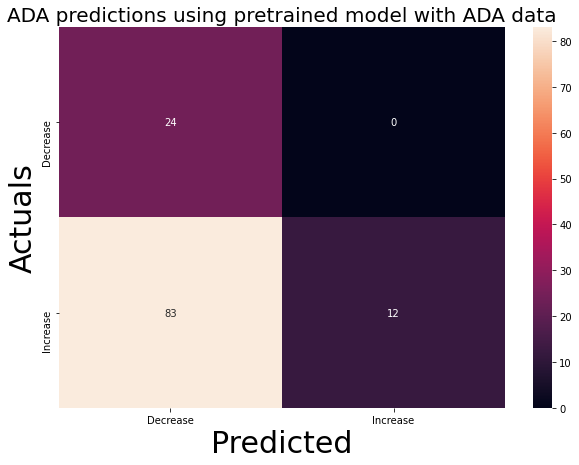

In [98]:
target_coin = 'ADA'
pretrained_model_coin = 'ADA'
preds = rnged_btcoin_model.predict(LSTM_validation_inputs[:-pred_range])

print(f1_score(LSTM_ranged_validation_outputs, np.round(preds), average='macro'))

create_conf_matrix(preds, LSTM_ranged_validation_outputs, target_coin, pretrained_model_coin, log_dir)

In [113]:
# Save the weights
#log_dir = r'C:\Users\georg\Documents\mine\εργασιες\μεταπτυχιακό\2ο εξάμηνο\Βαθιά Μηχανική Μάθηση\Γιαννακόπουλος\temp'
#rnged_btcoin_model.save_weights(log_dir+'/my_checkpoint')

In [23]:
#Save BTC trained model
#btcoin_model = rnged_btcoin_model
#eth_btcoin_model = rnged_btcoin_model
#usdt_doge_eth_btcoin_model = rnged_btcoin_model

In [ ]:
#Make prediction of different coin than this that the model was trained

In [80]:
preds = btcoin_model.predict(LSTM_validation_inputs[:-pred_range])

In [81]:
from sklearn.metrics import f1_score
f1_score(LSTM_ranged_validation_outputs, np.round(preds), average='macro')

0.4439252336448598

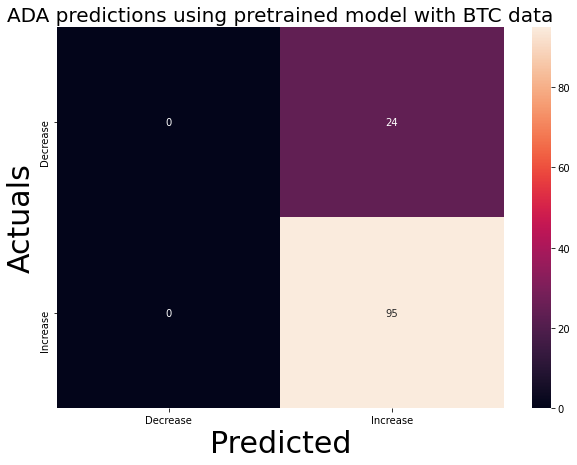

In [82]:
target_coin = 'ADA'
pretrained_model_coin = 'BTC'

create_conf_matrix(preds, LSTM_ranged_validation_outputs, target_coin, pretrained_model_coin, log_dir)

Lets try to train a little bit the pretrained model

In [92]:
#Clone BTC pre-trained model in order to further train it with another target coin data
further_trained_btc_model = tf.keras.models.clone_model(btcoin_model)

#Compile it
further_trained_btc_model.compile(loss="binary_crossentropy", optimizer='adam', 
                      metrics=[tfa.metrics.F1Score(average='macro', num_classes=pred_range*2)])

#Define early stopping
stp_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

#Train it
further_train_model_hist = further_trained_btc_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs,
                                       validation_data=(LSTM_validation_inputs[:-pred_range], LSTM_ranged_validation_outputs), 
                                           callbacks=[stp_early],
                                        epochs=500, batch_size=64, verbose=2, shuffle=True, workers=8)

Epoch 1/500
17/17 - 9s - loss: 0.6943 - f1_score: 0.3990 - val_loss: 0.7091 - val_f1_score: 0.1678
Epoch 2/500
17/17 - 0s - loss: 0.6929 - f1_score: 0.3409 - val_loss: 0.7155 - val_f1_score: 0.1678
Epoch 3/500
17/17 - 0s - loss: 0.6936 - f1_score: 0.3370 - val_loss: 0.7075 - val_f1_score: 0.1678
Epoch 4/500
17/17 - 0s - loss: 0.6943 - f1_score: 0.4464 - val_loss: 0.6926 - val_f1_score: 0.4296
Epoch 5/500
17/17 - 0s - loss: 0.6929 - f1_score: 0.4390 - val_loss: 0.7076 - val_f1_score: 0.1678
Epoch 6/500
17/17 - 0s - loss: 0.6937 - f1_score: 0.4775 - val_loss: 0.7033 - val_f1_score: 0.1678
Epoch 7/500
17/17 - 0s - loss: 0.6921 - f1_score: 0.5242 - val_loss: 0.7205 - val_f1_score: 0.1678
Epoch 8/500
17/17 - 0s - loss: 0.6928 - f1_score: 0.3722 - val_loss: 0.7044 - val_f1_score: 0.2176
Epoch 9/500
17/17 - 0s - loss: 0.6933 - f1_score: 0.4521 - val_loss: 0.7042 - val_f1_score: 0.1678
Epoch 10/500
17/17 - 0s - loss: 0.6897 - f1_score: 0.4160 - val_loss: 0.7095 - val_f1_score: 0.1678
Epoch 11/

17/17 - 0s - loss: 0.5585 - f1_score: 0.7047 - val_loss: 0.6044 - val_f1_score: 0.6186
Epoch 84/500
17/17 - 0s - loss: 0.5545 - f1_score: 0.7052 - val_loss: 0.5682 - val_f1_score: 0.6560
Epoch 85/500
17/17 - 0s - loss: 0.5381 - f1_score: 0.7447 - val_loss: 0.5151 - val_f1_score: 0.7024
Epoch 86/500
17/17 - 0s - loss: 0.5406 - f1_score: 0.7260 - val_loss: 0.5817 - val_f1_score: 0.6305
Epoch 87/500
17/17 - 0s - loss: 0.5635 - f1_score: 0.7026 - val_loss: 0.5212 - val_f1_score: 0.6912
Epoch 88/500
17/17 - 0s - loss: 0.5654 - f1_score: 0.6815 - val_loss: 0.7022 - val_f1_score: 0.5747
Epoch 89/500
17/17 - 0s - loss: 0.5821 - f1_score: 0.7242 - val_loss: 0.4385 - val_f1_score: 0.6022
Epoch 90/500
17/17 - 0s - loss: 0.5620 - f1_score: 0.7245 - val_loss: 0.4719 - val_f1_score: 0.6421
Epoch 91/500
17/17 - 0s - loss: 0.5555 - f1_score: 0.7216 - val_loss: 0.5264 - val_f1_score: 0.7036
Epoch 92/500
17/17 - 0s - loss: 0.5395 - f1_score: 0.7217 - val_loss: 0.5688 - val_f1_score: 0.6632
Epoch 93/500


In [93]:
log_dir = r'C:\Users\georg\Documents\mine\εργασιες\μεταπτυχιακό\2ο εξάμηνο\Βαθιά Μηχανική Μάθηση\Γιαννακόπουλος\temp'
create_plot(further_train_model_hist, log_dir, 'ADA')
create_F1_macro_plot(further_train_model_hist, log_dir, 'ADA')

In [94]:
preds = further_trained_btc_model.predict(LSTM_validation_inputs[:-pred_range])

In [95]:
f1_score(LSTM_ranged_validation_outputs, np.round(preds), average='macro')

0.6957674462645582

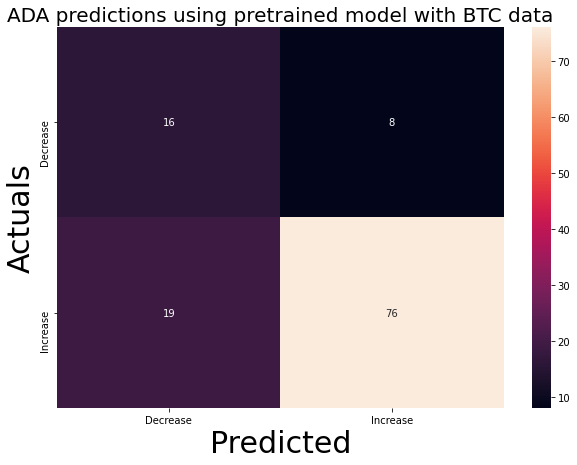

In [96]:
target_coin = 'ADA'
pretrained_model_coin = 'BTC'

create_conf_matrix(preds, LSTM_ranged_validation_outputs, target_coin, pretrained_model_coin, log_dir)